In [5]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import scipy
import os
import pandas as pd

import sys
sys.path.insert(1, '/home/cem/Documents/imps/src')

IS_YUP = False

def clamp_pc(points, max_len):
    lens = np.linalg.norm(points, axis=-1)
    points = points[lens < max_len]
    
    return points

def to_o2d(points, colors=None):    
    scan = o3d.geometry.PointCloud()

    scan.points = o3d.utility.Vector3dVector(points)
    
    if colors:
        scan.colors = o3d.utility.Vector3dVector(colors)
        
    return scan

def is_occupied(occ_map, x, y, resolution, top_left, threshold=0.05):
    """
    occ_map: Occupancy map (bool) of shape (N_x, N_y)
    x, y are the x and y coordinates
    resolution: Distance between each point in the occupancy map
    top_left: Top left coordinate (x, y)
    threshold: For soft occupancy
    
    IMPORTANT: Think of this as an image. So x is actually the vertical axis and y is actually the 
    horizontal axis. The ordering obeys array ordering.
    """
    assert (threshold % resolution) == 0
    
    i = np.abs(int((x - top_left[0]) // resolution))
    j = np.abs(int((y - top_left[1]) // resolution))
    n_step = int(threshold // resolution)
    
    lower_i = max(i-n_step, 0)
    upper_i = min(i+n_step, occ_map.shape[0])
    lower_j = max(j-n_step, 0)
    upper_j = min(j+n_step, occ_map.shape[1])

    occ = occ_map[lower_i:upper_i, lower_j:upper_j]
    return np.any(occ)

data_dir = '/home/cem/Desktop'
resolution = 0.015

scan1 = np.load(data_dir + '/Lidar1-scan.npy')
scan2 = np.load(data_dir + '/Lidar2-scan.npy')

scan1_l2w = np.load(data_dir + '/Lidar1-xform.npy')
scan2_l2w = np.load(data_dir + '/Lidar2-xform.npy')

n_scan1 = scan1.shape[0]
n_scan2 = scan2.shape[0]

scan1 = scan1.reshape(n_scan1, -1, 3) / 100
scan2 = scan2.reshape(n_scan2, -1, 3) / 100

In [6]:
o3d.visualization.draw_geometries([to_o2d(scan1[0])])

In [8]:
pcd_combined = o3d.geometry.PointCloud()
yup2zup = np.array([[1,0,0,0], [0,0,-1,0], [0,1,0,0], [0,0,0,1]])

if IS_YUP:
    xform = yup2zup
else:
    xform = np.eye(4)

for i in range(n_scan2):
    s1 = to_o2d(clamp_pc(scan1[i], 55)).transform(xform @ scan1_l2w[i])
    s2 = to_o2d(clamp_pc(scan2[i], 55)).transform(xform @ scan2_l2w[i])
    
    pcd_combined += s1
    pcd_combined += s2

o3d.visualization.draw_geometries([pcd_combined])

# Occupancy and Path Planning

In [25]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_combined, voxel_size=resolution)
o3d.visualization.draw_geometries([voxel_grid])

In [26]:
points = np.array(pcd_combined.points)
# Don't count floor and ceiling
points = points[(points[:, 2] > 0.5) & (points[:, 2] < 2.95)]

x_min, x_max = points[:, 0].min(), points[:, 0].max()
y_min, y_max = points[:, 1].min(), points[:, 1].max()
z_min, z_max = points[:, 2].min(), points[:, 2].max()

# This should be preferably the same with the voxel size
x_ = np.arange(x_min, x_max, resolution)
y_ = np.arange(y_min, y_max, resolution)
z_ = np.arange(z_min, z_max, resolution)

x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
xyz = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)], axis=1)

output = voxel_grid.check_if_included(o3d.utility.Vector3dVector(xyz))
output = np.array(output, dtype=np.bool).reshape(*x.shape)
occupancy = output.sum(axis=2) > 0

In [27]:
top_left = np.array((x_min, y_min))
bottom_right = np.array((x_max, y_max))
bounds = np.concatenate([top_left[None, :], bottom_right[None, :]], axis=0)

np.save(os.path.join(data_dir, 'occupancy', 'map.npy'), occupancy)
np.save(os.path.join(data_dir, 'occupancy', 'bounds.npy'), bounds)
is_occupied(occupancy, -1.42, 0.04, resolution, top_left, threshold=resolution)

False

In [ ]:
# Read the user trajectory
trj = pd.read_csv("/home/cem/Documents/6g_project_demo/traces.csv")
trj = np.array(trj)

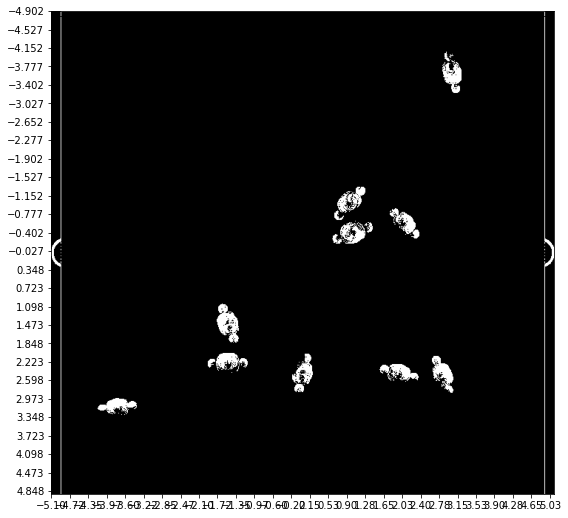

In [28]:
fig, ax = plt.subplots(figsize=(9, 9))

left, right, bottom, top = y_min, y_max, x_max, x_min
img = ax.imshow(occupancy, cmap='gray', extent=[left, right, bottom, top])
ax.set_yticks(x_[np.arange(0, len(x_), 25)]);
ax.set_xticks(y_[np.arange(0, len(y_), 25)]);
# ax.plot(trj[:, 1], trj[:, 0])

# plt.colorbar(img)

In [ ]:
N = 1000
device_height = 1.3

trj_z = np.ones((trj.shape[0], 1)) * device_height
trj_xyz = np.concatenate([trj, trj_z], axis=-1)

bs_location = np.array([-1, -2.5, 2.98]).reshape(1, 3)

alphas = np.linspace(0, 1, N).reshape(-1, 1, 1)
ray_paths = (1-alphas)*bs_location + alphas*trj_xyz

is_included = np.array(voxel_grid.check_if_included(o3d.utility.Vector3dVector(ray_paths.reshape(-1, 3))))
is_occluded = np.any(is_included.reshape(*ray_paths.shape[:2]), axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

left, right, bottom, top = y_min, y_max, x_max, x_min
img = ax.imshow(occupancy, cmap='gray', extent=[left, right, bottom, top])
ax.set_yticks(x_[np.arange(0, len(x_), 25)])
ax.set_xticks(y_[np.arange(0, len(y_), 25)])

ax.plot(trj[:, 1], trj[:, 0])
ax.scatter(trj[is_occluded, 1], trj[is_occluded, 0], c='C3')
ax.scatter(trj[~is_occluded, 1], trj[~is_occluded, 0])

# plt.colorbar(img)